In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from shapkit.shapley_values import ShapleyValues
from shapkit.inspector import inspector
from shapkit.monte_carlo_shapley import MonteCarloShapley, MonteCarloShapleyBatch
from shapkit.sgd_shapley import SGDshapley
from shapkit.plots import plot_shapley

from sklearn.ensemble import IsolationForest

# Load dataset

In [2]:
from sklearn.datasets import load_wine

wine = load_wine(return_X_y=False)
X = pd.DataFrame(wine.data, columns=wine.feature_names)
X.head(5)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0



# Train a ML model

In [3]:
model = IsolationForest(behaviour="new", contamination="auto", n_jobs=-1)
model.fit(X)

IsolationForest(behaviour='new', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=-1, random_state=None, verbose=0, warm_start=False)

# Define the game

In [4]:
d = X.shape[1]
n = 2**d - 2
d, n

(13, 8190)

## Reward function

def fc(z):
    if model.decision_function(z.reshape(1,-1)) < 0:
        return 1
    else:
        return 0

In [5]:
fc = lambda x: model.decision_function(x.reshape(1,-1))[0]

### Pick an anomaly $x$

In [6]:
idx_anomaly = np.argwhere(model.predict(X) == -1).flatten()
idx_x = np.random.choice(idx_anomaly, size=1)[0]
x = X.iloc[idx_x,:]
x_score = fc(x.values)
print(x)
print()
print("Prediction for x: {0:.2f}".format(x_score))

alcohol                          14.34
malic_acid                        1.68
ash                               2.70
alcalinity_of_ash                25.00
magnesium                        98.00
total_phenols                     2.80
flavanoids                        1.31
nonflavanoid_phenols              0.53
proanthocyanins                   2.70
color_intensity                  13.00
hue                               0.57
od280/od315_of_diluted_wines      1.96
proline                         660.00
Name: 158, dtype: float64

Prediction for x: -0.05


### Single reference in normal class

In [7]:
idx_normal = np.argwhere(model.predict(X) == 1).flatten()
idx_r = np.random.choice(idx_normal, size=1)[0]
reference = X.iloc[idx_r,:]
ref_score = fc(reference.values)
print(reference)
print()
print("Prediction for this reference: {0:.2f}".format(ref_score))

alcohol                          12.08
malic_acid                        2.08
ash                               1.70
alcalinity_of_ash                17.50
magnesium                        97.00
total_phenols                     2.23
flavanoids                        2.17
nonflavanoid_phenols              0.26
proanthocyanins                   1.40
color_intensity                   3.30
hue                               1.27
od280/od315_of_diluted_wines      2.96
proline                         710.00
Name: 100, dtype: float64

Prediction for this reference: 0.09


#### Approximation methods

##### Monte Carlo 

In [8]:
mc_shap = MonteCarloShapley(x=x, fc=fc, ref=reference, n_iter=100)
mc_shap

100%|██████████| 100/100 [00:37<00:00,  2.69it/s]


alcohol                        -0.015006
malic_acid                     -0.023145
ash                             0.003920
alcalinity_of_ash               0.007119
magnesium                      -0.010039
total_phenols                   0.014500
flavanoids                      0.014816
nonflavanoid_phenols            0.009493
proanthocyanins                -0.025724
color_intensity                -0.007193
hue                            -0.011848
od280/od315_of_diluted_wines   -0.003469
proline                        -0.012187
dtype: float64

In [8]:
%%time
mc_shap_batch = MonteCarloShapleyBatch(x=x, fc=model.decision_function, ref=reference, n_iter=1000)
mc_shap_batch

CPU times: user 380 ms, sys: 3.45 ms, total: 383 ms
Wall time: 379 ms


alcohol                        -0.013014
malic_acid                      0.001293
ash                             0.013637
alcalinity_of_ash              -0.017333
magnesium                      -0.000186
total_phenols                  -0.002680
flavanoids                     -0.010050
nonflavanoid_phenols           -0.010538
proanthocyanins                -0.026147
color_intensity                -0.053222
hue                            -0.012760
od280/od315_of_diluted_wines   -0.013774
proline                         0.001143
dtype: float64

##### SGD

In [10]:
sgd_est = SGDshapley(d, C=1)
sgd_shap = sgd_est.sgd(x=x, fc=fc, ref=reference, n_iter=50, step=.1, step_type="sqrt")
sgd_shap

100%|██████████| 50/50 [00:01<00:00, 33.18it/s]


alcohol                        -0.011061
malic_acid                     -0.008167
ash                            -0.004197
alcalinity_of_ash               0.004011
magnesium                      -0.010038
total_phenols                   0.019552
flavanoids                      0.003559
nonflavanoid_phenols           -0.000666
proanthocyanins                -0.016991
color_intensity                -0.012210
hue                            -0.006688
od280/od315_of_diluted_wines   -0.004302
proline                        -0.011563
dtype: float64

#### Plot 

/home/sgrah/Documents/shapkit/tutorials/shapkit/plots.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.get_axes()[0].set_xticklabels(xticks_label)


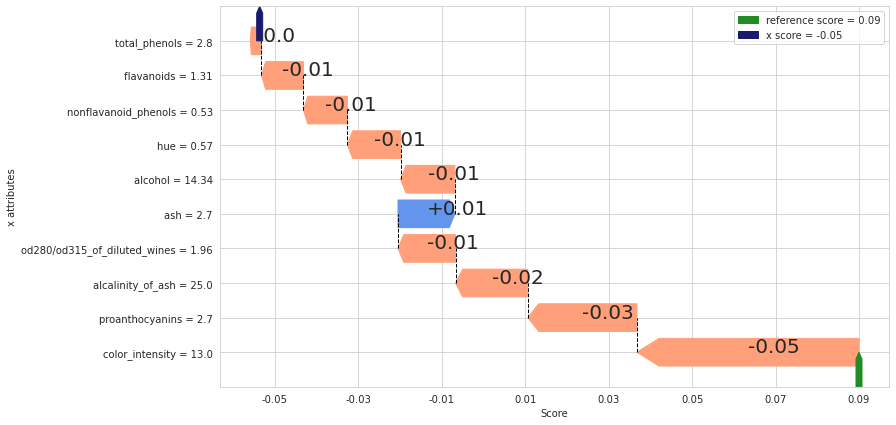

In [12]:
fig = plot_shapley(x=x, fc=fc, ref=reference, shapley_values=mc_shap_batch, n_attributes=10, no_show=True)

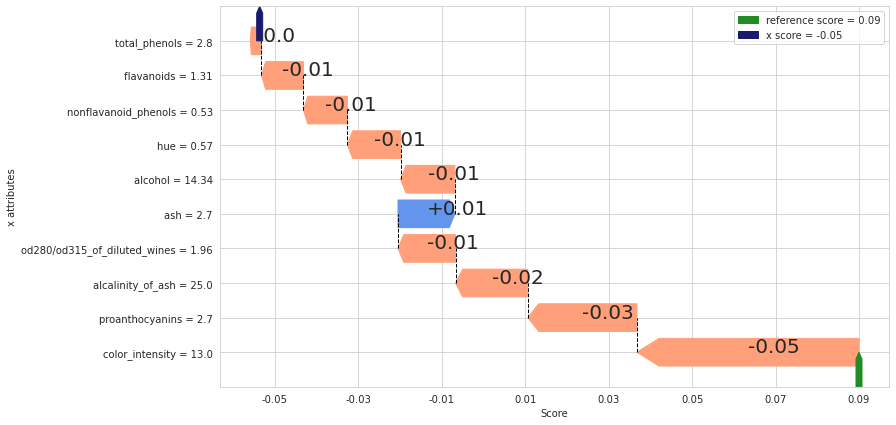

### Several references 

In [12]:
n_ref = 10
idx_normal = np.argwhere(model.predict(X) == 1).flatten()
idx_ref = np.random.choice(idx_normal, size=n_ref, replace=False).flatten()
references = X.iloc[idx_ref,:]
references.head(5)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
37,13.05,1.65,2.55,18.0,98.0,2.45,2.43,0.29,1.44,4.25,1.12,2.51,1105.0
142,13.52,3.17,2.72,23.5,97.0,1.55,0.52,0.50,0.55,4.35,0.89,2.06,520.0
132,12.81,2.31,2.40,24.0,98.0,1.15,1.09,0.27,0.83,5.70,0.66,1.36,560.0
86,12.16,1.61,2.31,22.8,90.0,1.78,1.69,0.43,1.56,2.45,1.33,2.26,495.0
67,12.37,1.17,1.92,19.6,78.0,2.11,2.00,0.27,1.04,4.68,1.12,3.48,510.0


#### Approximation methods

##### Monte Carlo 

In [13]:
mc_shaps = MonteCarloShapley(x=x, fc=fc, ref=references, n_iter=100)
mc_shaps

100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


alcohol                        -0.010072
malic_acid                     -0.022781
ash                             0.002137
alcalinity_of_ash               0.006074
magnesium                      -0.004183
total_phenols                   0.000858
flavanoids                     -0.008177
nonflavanoid_phenols           -0.005503
proanthocyanins                -0.027852
color_intensity                 0.000660
hue                            -0.002966
od280/od315_of_diluted_wines   -0.008139
proline                        -0.007053
dtype: float64

In [14]:
mc_shaps_batch = MonteCarloShapleyBatch(x=x, fc=model.decision_function, ref=references, n_iter=1000)
mc_shaps_batch

alcohol                        -0.010115
malic_acid                     -0.021597
ash                             0.002556
alcalinity_of_ash               0.005724
magnesium                      -0.003809
total_phenols                   0.000896
flavanoids                     -0.009544
nonflavanoid_phenols           -0.005368
proanthocyanins                -0.024453
color_intensity                 0.000304
hue                            -0.002672
od280/od315_of_diluted_wines   -0.010200
proline                        -0.006752
dtype: float64

#### Plots

In [17]:
plot_shapley(x=x, fc=fc, ref=references, shapley_values=mc_shaps_batch, n_attributes=15, no_show=True)

TypeError: plot_shapley() got an unexpected keyword argument 'no_show'